In [1]:
%matplotlib inline

import numpy as np
import itertools
import random
import math
import matplotlib.pyplot as plt

# Mancala

Mancala is a ancient family of games played played on many continents ([source, page 2623](https://doi.org/10.1007/978-94-007-3934-5_9947-1)). The word *mancala* comes from the Arabic word *نقل* transliterated *naqala* meaning literally "to move".

Mancala games usualy consists of two row of pits each containing a proportionaite amount of seeds, stones or shells.
Usualy, these games are played by two opponents who play sequentialy.

The goal for each opponent is to capture as many seeds as possible before the other.

-- Insert figure here

We will focus on Awalé (also called Oware or Owari), originating from Ghana and Kalah, a modern version invented by William Julius Champion Jr. circa 1940.

There are too many other existing variations to list them all here, but a few notable ones are Wari, Bao and Congkak.


## Perfect information

Mancala games are : 
 * sequential : the oppenents play one after the other,
 * hold no secret information : each playser has the same information about the game as the other
 * do not rely on randomness : the state of the game depends only on the actions taken sequentialy by each player and an action has a determinitc result.

This type of game is called a sequential perfect information game. ([6.1 page 89](http://ebour.com.ar/pdfs/A%20Course%20in%20Game%20Theory.pdf)).

-- Insert something about finite state machines ?

Other games in this category are for example Chess, Go, Checkers or even Tic-tac-toe and Connect Four.

This type of game is a particularly intersting field to study in computer science and artifical intelligence as they are easy to simulate.

While it might be tempting to enumerate every possible play of those games by starting a game and recusively try each legal action untill the end of the play, most of the time, this is not a feasible approch for most games due to the size of the state space.

For example, [Romein et al.](https://www.cs.vu.nl/pub/bal/awari.ps) claims that Awalé has 889,063,398,406 legal positions and the number of $\approx 2.08 * 10^170$ legal postions in Go has only [recently been determined](http://tromp.github.io/go/legal.html).

[Kalah is solved](http://kalaha.krus.dk/) 

## Oware

The b

# Awalé
Also known as awari and owari

## Solved

It might be solved by [Solving awari with parallel retrograde analysis](http://ieeexplore.ieee.org/abstract/document/1236468/)

------------

# Tree Search

In [2]:
from recordclass import recordclass

GAME_NODE_FIELDS = ['n_pits', 'seeds_per_pit', 'pits', 'current_player', 'captures', 'parent', 'children', 'wins', 'n_playouts']
        
class Game(recordclass('GameNode', GAME_NODE_FIELDS)):
    @classmethod
    def start_game(klass, n_pits=6, seeds_per_pit=4):
        return klass(
            n_pits,
            seeds_per_pit,
            pits=np.ones((n_pits * 2), dtype=int) * seeds_per_pit,
            current_player=0,
            captures=np.zeros((2,), dtype=int),
            parent=None,
            children=[None] * n_pits,
            wins=[0, 0],
            n_playouts=0
        )
    
    @property
    def view_from_current_player(self):
        shift = 0 if self.current_player == 0 else self.n_pits
        return np.roll(self.pits, shift)

    @property
    def legal_actions(self):
        # todo : add the Let the opponent play rule
        player_view = self.view_from_current_player
        return [x for x in range(self.n_pits) if player_view[x] != 0]
    
    @property
    def successors(self):
        children = [x for x in self.children if x is not None]
        successors = children + list(itertools.chain(*[x.successors for x in children]))
        return successors

    def step(self, action):
        assert 0 <= action < self.n_pits
        
        if self.children[action] is not None:
            new_game = self.children[action]
            captures = self.captures[self.current_player] - new_game.captures[self.current_player]
            return new_game, captures, new_game.game_finished
        
        target_pit = action if self.current_player == 0 else action - self.n_pits
        
        seeds = self.pits[target_pit]
        assert seeds != 0
        
        # copy attributes
        pits = np.copy(self.pits)
        captures = np.copy(self.captures)
        
        # empty the target pit
        pits[target_pit] = 0
        
        # fill the next pits
        pit_to_sow = target_pit
        while seeds > 0:
            pit_to_sow = (pit_to_sow + 1) % (self.n_pits * 2)
            if pit_to_sow != target_pit: # do not fill the target pit ever
                pits[pit_to_sow] += 1
                seeds -= 1
        
        # capture
        # count the captures of the play
        round_captures = 0
        if pit_to_sow in self.adverse_pits_idx:
            # if the last seed was in a adverse pit
            # we can try to collect seeds
            while pits[pit_to_sow] in (2, 3):
                # if the pit contains 2 or 3 seeds, we capture them
                captures[self.current_player] += pits[pit_to_sow]
                round_captures += pits[pit_to_sow]
                pits[pit_to_sow] = 0
                
                # go backwards
                pit_to_sow = (pit_to_sow - 1) % (self.n_pits * 2)
        
        # change player
        current_player = (self.current_player + 1) % 2
        
        new_game = type(self)(
            self.n_pits,
            self.seeds_per_pit,
            pits,
            current_player,
            captures,
            self,
            [None] * self.n_pits,
            [0, 0],
            0
        )
        
        self.children[action] = new_game
        return new_game, round_captures, new_game.game_finished
    
    @property
    def current_opponent(self):
        return (self.current_player + 1) % 2
    
    @property
    def adverse_pits_idx(self):
        if self.current_player == 1:
            return list(range(self.n_pits))
        else:
            return list(range(self.n_pits, self.n_pits * 2))
    
    @property
    def is_state_loop(self):
        ancestor = self.parent
        while ancestor is not None:
            if np.all(ancestor.pits == self.pits):
                return True
            ancestor = ancestor.parent
        return False
    
    @property
    def game_finished(self):
        no_moves_left = np.all(self.view_from_current_player[:self.n_pits] == np.zeros((self.n_pits,)))
        enough_captures = np.any(self.captures > (self.n_pits * self.seeds_per_pit))
        draw = np.all(self.captures == self.n_pits * self.seeds_per_pit)
        loop = self.is_state_loop
        return no_moves_left or enough_captures or draw or loop
    
    def show_state(self):
        if self.game_finished:
            print("Game finished")
        print("Current player: {} - Score: {}/{}\n{}".format(
            self.current_player,
            self.captures[self.current_player],
            self.captures[(self.current_player + 1) % 2],
            "-" * self.n_pits * 3
        ))
        
        pits = []
        for seeds in self.view_from_current_player:
            pits.append("{:3}".format(seeds))
        
        print("".join(reversed(pits[self.n_pits:])))
        print("".join(pits[:self.n_pits]))
    
    def update_stats(self, winner):
        assert winner in [0, 1]
        self.wins[winner] += 1
        self.n_playouts += 1
        if self.parent:
            self.parent.update_stats(winner)
    
    @property
    def winner(self):
        if not self.game_finished:
            return None
        return np.argmax(self.captures)
    
    @property
    def unvisited_actions(self):
        return [i for i, x in enumerate(self.children) if x is None]

    @property
    def legal_unvisited_actions(self):
        return list(set(self.unvisited_actions).intersection(set(self.legal_actions)))
    
    @property
    def expanded_children(self):
        return [x for x in self.children if x is not None]
    
    @property
    def is_fully_expanded(self):
        legal_actions = set(self.legal_actions)
        unvisited_actions = set(self.unvisited_actions)
        return len(legal_actions.intersection(unvisited_actions)) == 0
    
    @property
    def is_leaf_game(self):
        return self.children == [None] * self.n_pits
    
    @property
    def depth(self):
        if self.parent is None:
            return 0
        return 1 + self.parent.depth
    
    def to_dot(self, is_root=True):
        output = "%s -> %s;\n" % (id(self.parent), id(self)) if self.parent else "\n"
        output += '%s [label="%s/%s"]' % (id(self), self.wins, self.n_playouts)
        
        for child in self.children:
            if child is not None:
                output += child.to_dot(False) + "\n"
        
        if is_root:
            return """
            digraph BST {
                node [fontname="Arial"];
                %s
            }
            """ % output
        
        return output
    
    def __repr__(self):
        return "<Game {wins}/{n_playouts} player:{player} captures:{captures[0]}/{captures[1]}>".format(
            wins=self.wins,
            n_playouts=self.n_playouts,
            player=self.current_player,
            captures=self.captures
        )
        
        

In [3]:
g = Game.start_game(1, 2)

g, _, _ = g.step(0)
g, captues, done = g.step(0)
assert done


In [5]:
def max_rand(iterable, key=lambda x: x):
    maximum_value = max(key(x) for x in iterable)
    keep = [x for x in iterable if key(x) == maximum_value]
    return random.choice(keep)

# Play against each other

In [6]:
class Player:
    def play(self, their_action):
        # If we are the first player, there is no previous action
        if their_action != -1:
            # Play the opponent's move
            self.root, _, _ = self.root.step(their_action)
        else:
            assert self.player_id == 0, "Only the first player can have their_action=-1"
        
        action = self.get_action()
        self.root, _, _ = self.root.step(action)
        
        return action

class RandomPlayer(Player):
    def __init__(self, player_id):
        self.root = Game.start_game()
        self.player_id = player_id
    
    def get_action(self):
        return random.choice(self.root.legal_actions)
        
    
class GreedyPlayer(Player):
    def __init__(self, player_id, eps=0):
        self.root = Game.start_game()
        self.player_id = player_id
        self.eps = eps
    
    def get_action(self):
        # Choose a move
        children = []
        
        for legal_action in self.root.legal_actions:
            new_state, captures, finished = self.root.step(legal_action)
            if new_state.winner is None:
                win = 0
            elif new_state.winner == self.player_id:
                win = 1
            else:
                win = -1
            children.append((legal_action, captures, win))
        
        # order wins first, then by captures, then random
        sorted_children = sorted(children, key=lambda a_c_w: (-a_c_w[2], -a_c_w[1], random.random()))
        if random.random() < self.eps:
            action = random.choice(self.root.legal_actions)
        else:
            action = sorted_children[0][0]
            
        return action

    
class MCTSPlayer(Player):
    def __init__(self, player_id, budget):
        self.root = Game.start_game()
        self.player_id = player_id
        self.budget = budget

    def node_score(self, node):
        c = 1 / math.sqrt(2)
        exporation = node.wins[node.current_opponent] / node.n_playouts
        exploitation = math.sqrt(math.log(node.parent.n_playouts) / node.n_playouts)
        return exporation + c * exploitation

    def UCT_tree_policy(self, node):
        while not node.is_leaf_game:
            if node.is_fully_expanded:
                node = max_rand(node.expanded_children, key=self.node_score)
            else:
                action = random.choice(node.legal_unvisited_actions)
                node, _, _ = node.step(action)
        return node
    
    def explore_tree(self):
        # Choose a starting node
        node = self.UCT_tree_policy(self.root)

        # Run a simulation on that node
        finished = node.game_finished
        while not finished:
            # Random walk
            action = random.choice(node.legal_unvisited_actions)
            node, _, finished = node.step(action)

        # Backtrack stats
        node.update_stats(node.winner)
        
    
    def get_action(self):
        for _ in range(self.budget):
            self.explore_tree()
        
        
        # Now that the tree has been explored, choose the best direct children
        def action_score(x):
            node = self.root.children[x]
            if node is None:
                return -random.random()
            
            assert self.root.current_player == self.player_id
            assert node.current_player != self.player_id
            
            return node.wins[self.player_id]
        
        possible_actions = self.root.legal_actions
        
        return max(possible_actions, key=action_score)

    
class HumanPlayer(Player):
    def __init__(self, player_id):
        self.root = Game.start_game()
        self.player_id = player_id
    
    def get_action(self):
        self.root.show_state()
        action = int(input("Input move[0-5]: "))
        print("\n")
        return action

In [7]:
def play_game(player, opponent):
    game = Game.start_game()
    opponent_action = -1

    while not game.game_finished:
        player_action = player.play(opponent_action)
        game, captures, finished = game.step(player_action)

        player, opponent = opponent, player
        opponent_action = player_action
    return game

In [8]:
player = MCTSPlayer(0, 100)
opponent = HumanPlayer(1)

#endstate = play_game(player, opponent)
#print(endstate.winner)
#endstate.show_state()

# Fight

In [16]:
%%time
RUNS = 15
BUDGET = 200
factories = [
    ("Random", lambda x: RandomPlayer(x)),
    ("Greedy", lambda x: GreedyPlayer(x)),
    ("MCTS UCT", lambda x: MCTSPlayer(x, BUDGET)),
]
names = [x[0] for x in factories]

res = np.zeros((len(factories), len(factories), 2))
for (i, (name1, factory1)), (j, (name2, factory2)) in itertools.product(enumerate(factories), repeat=2):
    if i >= j:
        continue
    for _ in range(RUNS):
        player = factory1(0)
        opponent = factory2(1)

        endstate = play_game(player, opponent)
        print(name1, "vs", name2, "winner=", endstate.winner)
        res[i,j, endstate.winner] += 1

ratios = res[:,:, 1] - res[:,:, 0]

Random vs Greedy winner= 1
Random vs Greedy winner= 1
Random vs Greedy winner= 1
Random vs Greedy winner= 1
Random vs Greedy winner= 1
Random vs Greedy winner= 1
Random vs Greedy winner= 1
Random vs Greedy winner= 0
Random vs Greedy winner= 0
Random vs Greedy winner= 1
Random vs Greedy winner= 1
Random vs Greedy winner= 1
Random vs Greedy winner= 1
Random vs Greedy winner= 1
Random vs Greedy winner= 1
Random vs MCTS UCT winner= 1
Random vs MCTS UCT winner= 1
Random vs MCTS UCT winner= 1
Random vs MCTS UCT winner= 1
Random vs MCTS UCT winner= 1
Random vs MCTS UCT winner= 1
Random vs MCTS UCT winner= 1
Random vs MCTS UCT winner= 1
Random vs MCTS UCT winner= 1
Random vs MCTS UCT winner= 1
Random vs MCTS UCT winner= 1
Random vs MCTS UCT winner= 1
Random vs MCTS UCT winner= 1
Random vs MCTS UCT winner= 1
Random vs MCTS UCT winner= 1
Greedy vs MCTS UCT winner= 1
Greedy vs MCTS UCT winner= 1
Greedy vs MCTS UCT winner= 1
Greedy vs MCTS UCT winner= 1
Greedy vs MCTS UCT winner= 1
Greedy vs MCTS 

<Figure size 432x288 with 0 Axes>

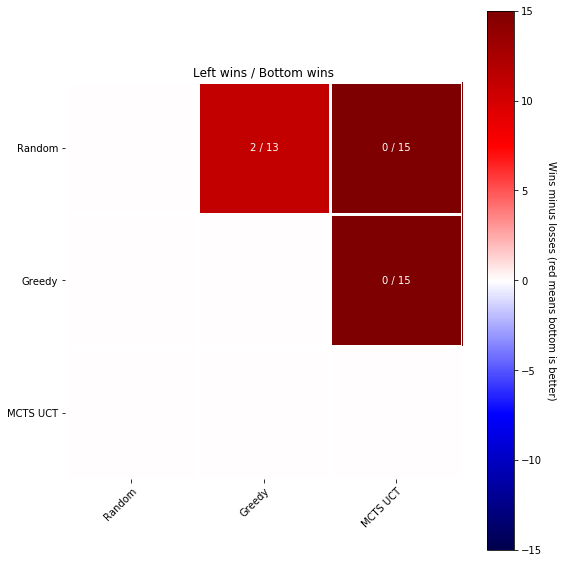

In [17]:
plt.set_cmap('seismic')

fig, ax = plt.subplots(figsize=(8,8))

bornes = abs(ratios).max()
im = ax.imshow(ratios, vmin=-bornes, vmax=bornes)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Wins minus losses (red means bottom is better)", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))

ax.set_xticklabels(names)
ax.set_yticklabels(names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(names)):
    for j in range(len(names)):
        s = "%i / %i" % (res[i, j, 0], res[i, j, 1])
        text = ax.text(j, i, s,
                       ha="center", va="center", color="w")

for edge, spine in ax.spines.items():
        spine.set_visible(False)
ax.set_xticks(np.arange(ratios.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(ratios.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)
        
ax.set_title("Left wins / Bottom wins")
fig.tight_layout()
plt.show()

## Compare

In [12]:
crash

NameError: name 'crasj' is not defined

# Learning

# Deep mind

 * Alpha Go [Mastering the game of Go with deep neural networks and tree search](https://storage.googleapis.com/deepmind-media/alphago/AlphaGoNaturePaper.pdf)
 * Alpha Go Zero [Mastering the game of Go without human knowledge](https://www.nature.com/articles/nature24270.epdf?author_access_token=VJXbVjaSHxFoctQQ4p2k4tRgN0jAjWel9jnR3ZoTv0PVW4gB86EEpGqTRDtpIz-2rmo8-KG06gqVobU5NSCFeHILHcVFUeMsbvwS-lxjqQGg98faovwjxeTUgZAUMnRQ)
 * Alpha Zero [Mastering Chess and Shogi by Self-Play with a
General Reinforcement Learning Algorithm](https://arxiv.org/pdf/1712.01815.pdf)

In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [ ]:
n_pits = 6
seeds_per_pit = 4

dropout = 0.3
lr = 0.001
conv_size = 3

inputlen = n_pits * 2
padd_len = conv_size - 1
num_classes = n_pits * seeds_per_pit * 2

Left_pad = Lambda(lambda x: x[:, -padd_len:])

def _conv_pad(x):
    return Concatenate(axis=1)([
        Left_pad(x),
        x
    ])
Conv_pad = Lambda(_conv_pad)

board = Input(shape=(inputlen,))
board_reshaped = Reshape((inputlen, 1))(board)

conv1 = Activation('relu')(BatchNormalization(axis=2)(Conv1D(20, conv_size, padding='valid')(Conv_pad(board_reshaped))))
conv2 = Activation('relu')(BatchNormalization(axis=2)(Conv1D(20, conv_size, padding='valid')(Conv_pad(conv1))))
conv3 = Activation('relu')(BatchNormalization(axis=2)(Conv1D(20, conv_size, padding='valid')(Conv_pad(conv2))))

flat = Flatten()(conv3)       

fc1 = Dropout(dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(256)(flat))))
fc2 = Dropout(dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(128)(fc1))))

policy = Dense(n_pits, activation='softmax', name='policy')(fc2)
value = Dense(1, activation='tanh', name='value')(fc2)

model = Model(inputs=board, outputs=[policy, value])
model.compile(loss=['categorical_crossentropy','mean_squared_error'], optimizer=Adam(lr))

In [ ]:
model.summary()

# Train

In [ ]:
root = game = Game.start_game()

finished = False
while not finished:
    view = game.view_from_current_player
    view = np.reshape(view, (1,) + view.shape)
    
    policy, _ = model.predict_on_batch(view)
    action = np.argmax(policy[0])
    if action not in game.legal_actions:
        action = random.choice(game.legal_actions)
        
    game, _, finished = game.step(action)
game.update_stats(game.winner)
game
#model.train_on_batch(x, y)